In [1]:
#Drive daki dosyalara erişmek için izin verir.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#ilgili calisma klasorune gecer.
import os
os.chdir("/content/drive/MyDrive/WHU")

In [3]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
!nvidia-smi

Wed Dec 27 06:09:06 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(2)

In [6]:
import os
import cv2
import shutil
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.utils import normalize
import glob
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU,Input,AveragePooling2D, Activation, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, MaxPool2D
from tensorflow.keras.layers import Lambda,GlobalMaxPooling2D, DepthwiseConv2D, Reshape, Permute, Add, concatenate, Concatenate, Multiply


from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K
import time

In [8]:
import os
import cv2
from tqdm import tqdm
from glob import glob
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import albumentations as A

In [9]:
print(tf.executing_eagerly())

True


In [10]:
tr = np.load('/content/drive/MyDrive/WHU/WHU_build_area_train_set_80_percent.npz', allow_pickle=True)
vl = np.load('/content/drive/MyDrive/WHU/WHU_build_area_val_set_10_percent.npz', allow_pickle=True)
ts = np.load('/content/drive/MyDrive/WHU/WHU_build_area_test_set_10_percent.npz', allow_pickle=True)

In [11]:
print(tr.files)
print(vl.files)
print(ts.files)

['tr_img', 'tr_msk']
['vl_img', 'vl_msk']
['ts_img', 'ts_msk']


In [12]:
#isimlere göre np.array cagrilir.
tr_img = tr['tr_img']
tr_lbl = tr['tr_msk']

vl_img = vl['vl_img']
vl_lbl = vl['vl_msk']

ts_img = ts['ts_img']
ts_lbl = ts['ts_msk']

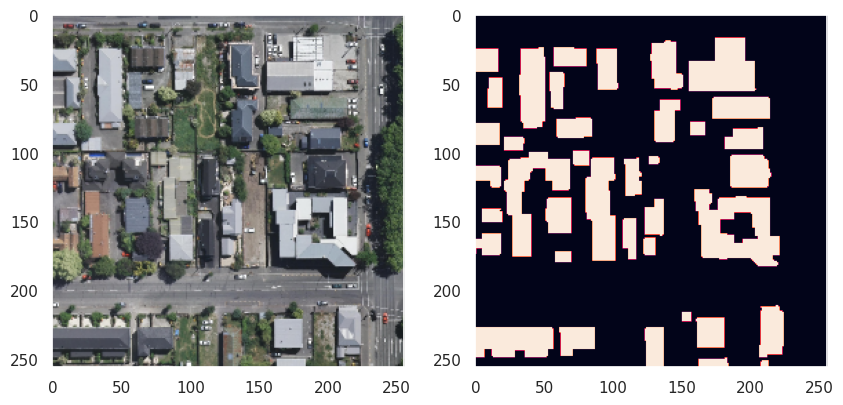

In [13]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.grid(False)
plt.imshow((tr_img[42]))
plt.subplot(1, 2, 2)
plt.grid(False)
plt.imshow(tr_lbl[42])

In [14]:
np.unique(tr_lbl) #label 255 -> 1 yapilmalidir.

array([  0, 255], dtype=uint8)

In [15]:
#bu fonk. farklı etikete sahip maskeleri 0,1,2 ... olarak etiketler.
def mask_to_label_encoder(_mask):
  new_mask = np.zeros(_mask.shape,dtype=np.uint8)
  lbl_id = np.unique(_mask)
  print("new id \t: old id\n----------------")
  for i, id in enumerate(lbl_id):
    print(i, " \t: ",id)
    new_mask[np.where(_mask == id)] = i
  return new_mask

In [16]:
tr_lbl = mask_to_label_encoder(tr_lbl)
vl_lbl = mask_to_label_encoder(vl_lbl)
ts_lbl = mask_to_label_encoder(ts_lbl)

new id 	: old id
----------------
0  	:  0
1  	:  255
new id 	: old id
----------------
0  	:  0
1  	:  255
new id 	: old id
----------------
0  	:  0
1  	:  255


In [17]:
tr_image = np.array(tr_img , dtype='float32')
tr_mask = np.array(tr_lbl , dtype= 'float32')

ts_image = np.array(ts_img , dtype='float32')
ts_mask = np.array(ts_lbl , dtype= 'float32')

vl_image = np.array(vl_img , dtype='float32')
vl_mask = np.array(vl_lbl , dtype= 'float32')

print(tr_image.shape, tr_mask.shape)
print(ts_image.shape, ts_mask.shape)
print(vl_image.shape, vl_mask.shape)

(2399, 256, 256, 3) (2399, 256, 256)
(300, 256, 256, 3) (300, 256, 256)
(300, 256, 256, 3) (300, 256, 256)


In [18]:
def augment_data(images, masks):
  H = W = 256
  new_image = []
  new_mask = []
  imag = []
  mask = []

  aug = A.Compose([
      A.RandomSizedCrop((256-80, 256-10), H, W),
      A.ShiftScaleRotate(),
      A.RGBShift(),
      A.Blur(),
      A.GaussNoise(),
      A.ChannelShuffle(p=1)
      ],p=1)

  for img, msk in tqdm(zip(images, masks), total=len(images)):
    augmented = aug(image=img, mask=msk)
    imag.append(augmented["image"])
    mask.append(augmented["mask"])
    imag.append(img)
    mask.append(msk)

  for i,m in tqdm(zip(imag, mask), total=len(imag)):
      new_image.append(cv2.resize(i, (W, H)))
      new_mask.append(cv2.resize(m, (W, H)))
  return np.array(new_image), np.array(new_mask)

In [19]:
"""tr_image, tr_mask = augment_data(tr_image, tr_mask)
vl_image, vl_mask = augment_data(vl_image, vl_mask)"""

'tr_image, tr_mask = augment_data(tr_image, tr_mask)\nvl_image, vl_mask = augment_data(vl_image, vl_mask)'

In [20]:
print(tr_image.shape, tr_mask.shape)
print(vl_image.shape, vl_mask.shape)

(2399, 256, 256, 3) (2399, 256, 256)
(300, 256, 256, 3) (300, 256, 256)


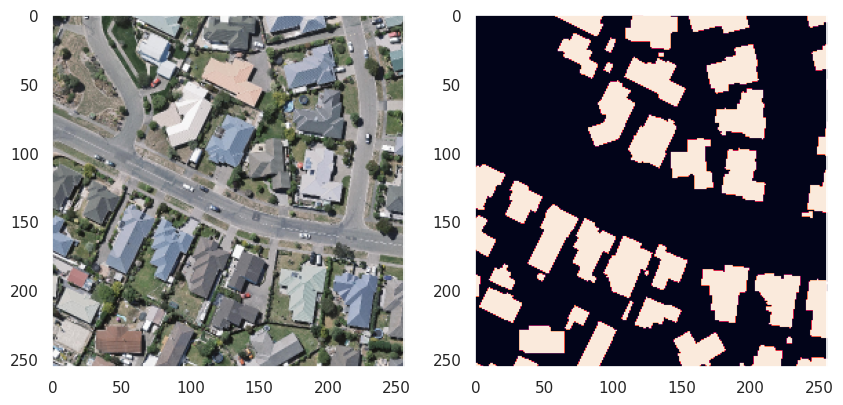

In [21]:
image_num = 23
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.grid(False)
plt.imshow((tr_image[image_num])/255)
plt.subplot(1, 2, 2)
plt.grid(False)
plt.imshow(tr_mask[image_num])

In [22]:
tr_mask = np.expand_dims(tr_mask, axis = 3)
ts_mask = np.expand_dims(ts_mask, axis = 3)
vl_mask = np.expand_dims(vl_mask, axis = 3)

In [23]:
print(tr_image.shape, tr_mask.shape)
print(ts_image.shape, ts_mask.shape)
print(vl_image.shape, vl_mask.shape)

(2399, 256, 256, 3) (2399, 256, 256, 1)
(300, 256, 256, 3) (300, 256, 256, 1)
(300, 256, 256, 3) (300, 256, 256, 1)


normalization

In [24]:
tr_image= tr_image / 255.0
ts_image = ts_image / 255.0
vl_image = vl_image / 255.0

In [25]:
#losses
def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

def jaccard_coef(y_true, y_pred):
    y_true = tf.cast(y_true, y_pred.dtype)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    """y_true_f = tf.cast(y_true_f, tf.float32)
    y_pred_f = tf.cast(y_pred_f, tf.float32)"""
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jaccard_coef_loss(y_true, y_pred):
    return 1.0 - jaccard_coef(y_true, y_pred)

def dice_coef(y_true, y_pred):
    #y_true = tf.cast(y_true, y_pred.dtype)
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):

    return 1.0 - dice_coef(y_true, y_pred)

In [26]:
EPOCH = 100

In [27]:
#asymmetric convolution
def convolution_block_2(block_input, n_filters=128, kernel_size=3, stride=1, dilation_rate=1,padding="same",use_bias=False, _name=''):
  ks1, ks2, ks3, ks4 = kernel_size, 1, 1, kernel_size
  x = Conv2D(
      n_filters,
      kernel_size=(ks1, ks2),
      strides=stride,
      dilation_rate=dilation_rate,
      padding="same",
      use_bias=use_bias,
      kernel_initializer=keras.initializers.HeNormal(),
      name=str(_name)+'_Conv1'
  )(block_input)
  x = Conv2D(
      n_filters,
      kernel_size=(ks3, ks4),
      strides=stride,
      dilation_rate=dilation_rate,
      padding="same",
      use_bias=use_bias,
      kernel_initializer=keras.initializers.HeNormal(),
      name=str(_name)+'_Conv2'
  )(x)
  x = BatchNormalization(name=str(_name)+'_batchNorm1')(x)
  return tf.nn.relu(x,name=str(_name)+'_relu1')

In [28]:
def DilatedSpatialPyramidPooling(dspp_input, n_filters):

    dims = dspp_input.shape

    out_1 = tf.keras.layers.Conv2D(filters=n_filters,kernel_size=(1,1), kernel_initializer='he_normal', padding='same', name='GDASPP_Conv_Block1')(dspp_input)
    out_6 = convolution_block_2(dspp_input,n_filters, kernel_size=3, dilation_rate=6, _name='GDASPP_Conv_Block2')
    out_12 = convolution_block_2(dspp_input,n_filters, kernel_size=3, dilation_rate=12, _name='GDASPP_Conv_Block3')
    out_18 = convolution_block_2(dspp_input,n_filters, kernel_size=3, dilation_rate=18, _name='GDASPP_Conv_Block4')

    con_1 = tf.keras.layers.Concatenate(axis=3)([out_1,out_6,out_12,out_18])

    #---------------------------------------------------#
    #----------------------SAM--------------------------#
    #---------------------------------------------------#

    sig_1   = tf.keras.layers.Conv2D(filters=1,kernel_size=(5,5), activation='sigmoid', kernel_initializer='he_normal', padding='same', use_bias=False)(out_1)
    sig_6   = tf.keras.layers.Conv2D(filters=1,kernel_size=(5,5), activation='sigmoid', kernel_initializer='he_normal', padding='same', use_bias=False)(out_6)
    sig_12 = tf.keras.layers.Conv2D(filters=1,kernel_size=(5,5), activation='sigmoid', kernel_initializer='he_normal', padding='same', use_bias=False)(out_12)
    sig_18 = tf.keras.layers.Conv2D(filters=1,kernel_size=(5,5), activation='sigmoid', kernel_initializer='he_normal', padding='same', use_bias=False)(out_18)

    mul_1   = tf.keras.layers.Multiply()([out_1, sig_1])
    mul_6   = tf.keras.layers.Multiply()([out_6, sig_6])
    mul_12  = tf.keras.layers.Multiply()([out_12, sig_12])
    mul_18  = tf.keras.layers.Multiply()([out_18, sig_18])

    con_2 = tf.keras.layers.Concatenate(axis=3)([mul_1,mul_6,mul_12,mul_18])
    #---------------------------------------------------#
    #----------------------CAM--------------------------#
    #---------------------------------------------------#
    x = tf.keras.layers.GlobalAveragePooling2D()(con_2)
    x = tf.keras.layers.Dense(units=n_filters*4)(x)
    x = tf.keras.layers.Dense(units=n_filters*4)(x)
    x = tf.keras.layers.Activation('sigmoid')(x)

    cam_reshape = tf.keras.layers.Reshape(( 1, 1, n_filters*4))(x)
    mul_2 = tf.keras.layers.Multiply()([con_2, cam_reshape])
    add_2 = tf.keras.layers.Add()([con_1, mul_2])
    #---------------------------------------------------#

    con_4 = convolution_block_2(add_2, kernel_size=1, _name='GDASPP_Conv_Block5')

    return con_4

In [29]:
#standard convolution
def conv2d(block_input, num_filters=128, kernel_size=3, stride=1, dilation_rate=1,padding="same", groups=1, use_bias=False):
  x = Conv2D(
      num_filters,
      kernel_size=kernel_size,
      strides = stride,
      groups=groups,
      dilation_rate=dilation_rate,
      padding="same",
      use_bias=use_bias,
      kernel_initializer=keras.initializers.HeNormal()
  )(block_input)
  return x

In [30]:
#depthwise Convolution
def DWConv2d(block_input, kernel_size=3, strides = (1,1), dilation_rate=1, padding="same", depth_multiplier=1, use_bias=True):
  x = DepthwiseConv2D(
      kernel_size =  kernel_size,
      strides = strides,
      padding = padding,
      depth_multiplier=depth_multiplier,
      data_format=None,
      dilation_rate=dilation_rate,
      activation=None,
      use_bias=use_bias,
      depthwise_initializer='glorot_uniform'
  )(block_input)
  return x

In [31]:
#Encoder-Decoder Residual Block
def EDRB(_x, groups, dilated_rate, n_filters): #efficient Residual Bottleneck Module
  #NOT:3x1 ve 1x3 conv islemleri art arda yapilirsa 3x3 conv islemine denk gelir
  #ancak islem sayisi direkt 3x3 conv a göre azaltilir. Bu islem soerable convolution olarak gecer.
  #-------------------------------------------------------------------------------------#
  #-----------------------------Fist Block----------------------------------------------#

  #1x1 Kernel Conv
  x_1 = conv2d(_x, num_filters=n_filters//2, kernel_size=(1,1), dilation_rate=1, padding="same",use_bias=True)
  #batch norm. and relu
  x_1 = BatchNormalization()(x_1)
  x_1 = tf.nn.relu(x_1)

  #3x1 DWConv
  x_dw = DWConv2d(x_1, kernel_size=(3,1), strides = (1,1), dilation_rate=1, padding="same", depth_multiplier=1, use_bias=True)
  #1x3 DWConv
  x_dw = DWConv2d(x_dw, kernel_size=(1,3), strides = (1,1), dilation_rate=1, padding="same", depth_multiplier=1, use_bias=True)
  #batch norm. and relu
  x_dw = BatchNormalization()(x_dw)
  x_dw = tf.nn.relu(x_dw)

  #3x1 Kernel Conv
  x_co = conv2d(x_1, num_filters=n_filters//2, kernel_size=(3,1), dilation_rate = dilated_rate, padding="same",use_bias=True)
  #1x3 Kernel Conv
  x_co = conv2d(x_co, num_filters=n_filters//2, kernel_size=(1,3), dilation_rate = dilated_rate, padding="same",use_bias=True)
  #batch norm. and relu
  x_co = BatchNormalization()(x_co)
  x_co = tf.nn.relu(x_co)

  #Concatenate
  x_cnc = concatenate([x_dw, x_co], axis=3)

  #1x1 conv
  x_2 = conv2d(x_cnc, num_filters=n_filters//2, kernel_size=(1,1), dilation_rate=1, padding="same",use_bias=True)
  #batch norm. and relu
  x_2 = BatchNormalization()(x_2)
  x_2 = tf.nn.relu(x_2)

  #Add
  x_add = Add()([x_1, x_2])

  #-------------------------------------------------------------------------------------#
  #-----------------------------Second Block--------------------------------------------#

  #1x1 Kernel Conv
  x2_1 = conv2d(x_add, num_filters=n_filters//2, kernel_size=(1,1), dilation_rate=1, padding="same",use_bias=True)
  #batch norm. and relu
  x2_1 = BatchNormalization()(x2_1)
  x2_1 = tf.nn.relu(x2_1)

  #3x1 DWConv
  x2_dw = DWConv2d(x2_1, kernel_size=(3,1), strides = (1,1), dilation_rate=1, padding="same", depth_multiplier=1, use_bias=True)
  #1x3 DWConv
  x2_dw = DWConv2d(x2_dw, kernel_size=(1,3), strides = (1,1), dilation_rate=1, padding="same", depth_multiplier=1, use_bias=True)
  #batch norm. and relu
  x2_dw = BatchNormalization()(x2_dw)
  x2_dw = tf.nn.relu(x2_dw)

  #3x1 Kernel Conv
  x2_co = conv2d(x2_1, num_filters=n_filters//2, kernel_size=(3,1), dilation_rate = dilated_rate, padding="same",use_bias=True)
  #1x3 Kernel Conv
  x2_co = conv2d(x2_co, num_filters=n_filters//2, kernel_size=(1,3), dilation_rate = dilated_rate, padding="same",use_bias=True)
  #batch norm. and relu
  x2_co = BatchNormalization()(x2_co)
  x2_co = tf.nn.relu(x2_co)

  #Concatenate
  x2_cnc = concatenate([x2_dw, x2_co], axis=3)

  #1x1 conv
  x2_2 = conv2d(x2_cnc, num_filters=n_filters//2, kernel_size=(1,1), dilation_rate=1, padding="same",use_bias=True)
  #batch norm. and relu
  x2_2 = BatchNormalization()(x2_2)
  x2_2 = tf.nn.relu(x2_2)

  #Add
  x2_add = Add()([x_add, x2_2])

  x2_add = Add()([x_1, x2_add])

  return x2_add

In [32]:
def downsample_block(x, groups, dilated_rate, n_filters):
   f = EDRB(x, groups=groups, dilated_rate=dilated_rate, n_filters=n_filters)
   p = MaxPool2D(2)(f)
   return f, p

In [33]:
def upsample_block(x, groups, dilated_rate, conv_features, n_filters):
   # upsample
   x = Conv2DTranspose(n_filters, kernel_size=3, strides=2, padding="same", activation='relu')(x)
   # concatenate
   x = concatenate([x, conv_features])
   # Conv2D twice with ReLU activation
   x = EDRB(x, groups=groups, dilated_rate=dilated_rate, n_filters=n_filters)
   return x

In [34]:
def proposed_model():
  # inputs
  inputs = Input(shape=(256,256,3))
  # encoder: contracting path - downsample
  # 1 - downsample
  f1, p1 = downsample_block(inputs, groups=1, dilated_rate=2, n_filters=24)
  # 2 - downsample
  f2, p2 = downsample_block(p1, groups=1, dilated_rate=4, n_filters=48)
  # 3 - downsample
  f3, p3 = downsample_block(p2, groups=1, dilated_rate=8, n_filters=72)
  # 4 - downsample
  f4, p4 = downsample_block(p3, groups=1, dilated_rate=16, n_filters=96)
  # 5 - bottleneck
  #bottleneck = double_conv_block(p4, 512)
  #yeni blok, downsample blok 2

  bottleneck = DilatedSpatialPyramidPooling(p4, 72)
  # decoder: expanding path - upsample
  # 6 - upsample
  u6 = upsample_block(bottleneck, groups=1, dilated_rate=16, conv_features=f4, n_filters=96)
  # 7 - upsample
  u7 = upsample_block(u6, groups=1, dilated_rate=8, conv_features=f3, n_filters=72)
  # 8 - upsample
  u8 = upsample_block(u7, groups=1, dilated_rate=4, conv_features=f2, n_filters=48)
  # 9 - upsample
  u9 = upsample_block(u8, groups=1, dilated_rate=2, conv_features=f1, n_filters=24)
  # outputs
  outputs = Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)
  # unet model with Keras Functional API
  model = tf.keras.Model(inputs, outputs, name="U-Net")
  return model

In [35]:
proposed_model = proposed_model()
proposed_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 12)         48        ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 12)         48        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 tf.nn.relu (TFOpLambda)     (None, 256, 256, 12)         0         ['batch_normalization[0][0

In [36]:
opt = keras.optimizers.Adam(learning_rate=0.01)
proposed_model.compile(optimizer=opt,
              loss= dice_coef_loss,
              metrics=[jaccard_coef,dice_coef,'accuracy'])

In [37]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                         patience =10,
                         verbose = 1,
                         factor = 0.1,
                         min_lr = 0.00001)

mcp = ModelCheckpoint(filepath=r"model_hpo.h5",
    save_weights_only=True,
    monitor='val_jaccard_coef',
    mode='auto',
    verbose=0,
    save_best_only=False)

In [38]:
EPOCH = 100

In [39]:
now = time.time()
history1 = proposed_model.fit(tr_image, tr_mask, batch_size=16, epochs=EPOCH, validation_data=(vl_image, vl_mask), shuffle=True, callbacks = [lrd , mcp])
end = time.time()
print('time: ', end - now)

Epoch 1/100
150/150 [==============================] - 107s 264ms/step - loss: 0.1869 - jaccard_coef: 0.6928 - dice_coef: 0.8132 - accuracy: 0.9212 - val_loss: 0.7751 - val_jaccard_coef: 0.1274 - val_dice_coef: 0.2256 - val_accuracy: 0.7374 - lr: 0.0100
Epoch 2/100
150/150 [==============================] - 34s 229ms/step - loss: 0.1338 - jaccard_coef: 0.7648 - dice_coef: 0.8662 - accuracy: 0.9471 - val_loss: 0.9930 - val_jaccard_coef: 0.0035 - val_dice_coef: 0.0069 - val_accuracy: 0.8067 - lr: 0.0100
Epoch 3/100
150/150 [==============================] - 33s 220ms/step - loss: 0.1271 - jaccard_coef: 0.7752 - dice_coef: 0.8729 - accuracy: 0.9498 - val_loss: 0.3433 - val_jaccard_coef: 0.4916 - val_dice_coef: 0.6569 - val_accuracy: 0.8237 - lr: 0.0100
Epoch 4/100
150/150 [==============================] - 33s 220ms/step - loss: 0.1142 - jaccard_coef: 0.7957 - dice_coef: 0.8858 - accuracy: 0.9548 - val_loss: 0.1759 - val_jaccard_coef: 0.7014 - val_dice_coef: 0.8242 - val_accuracy: 0.9387 

In [40]:
proposed_model.save('WHU_proposed_model.h5')
import pickle
with open('WHU_proposed_model.pickle' , 'wb') as file:
  pickle.dump(history1.history,file)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
proposed_model = tf.keras.models.load_model('WHU_proposed_model.h5', custom_objects = {'dice_coef': dice_coef,
            'jaccard_coef_loss': jaccard_coef_loss,
            'jaccard_coef':jaccard_coef,
            'dice_coef_loss': dice_coef_loss})

In [42]:
pred_val = proposed_model.predict(vl_image)
pred_test = proposed_model.predict(ts_image)

true_test = (ts_mask>0.5).flatten() #orjinal test maskesi
true_val  = (vl_mask>0.5).flatten() #orjinal validation maskesi
pred_test = (pred_test>0.5).flatten()
pred_val = (pred_val>0.5).flatten()

#test miou  #keras in MeanIOU fonksiyonu bu camvid veri seti için
#build ve background nesnelerinin ortalamasini alir. build = 1 ve Background = 0 dir.
miou = tf.keras.metrics.MeanIoU(num_classes= 2)
miou.update_state(true_test, pred_test)
print('Test data MIOU :',miou.result().numpy())

#val miou
miou = tf.keras.metrics.MeanIoU(num_classes= 2)
miou.update_state(true_val, pred_val)
print('Validation data MIOU :',miou.result().numpy())

10/10 [==============================] - 1s 116ms/step
Test data MIOU : 0.92069864
Validation data MIOU : 0.9281266


In [43]:
import pickle
import matplotlib.pyplot as plt

In [44]:
proposed_deeplab = pickle.load(open('WHU_proposed_model.pickle', "rb"))

In [45]:
print('\n',proposed_deeplab.keys())


 dict_keys(['loss', 'jaccard_coef', 'dice_coef', 'accuracy', 'val_loss', 'val_jaccard_coef', 'val_dice_coef', 'val_accuracy', 'lr'])


In [46]:
epochs = range(EPOCH)

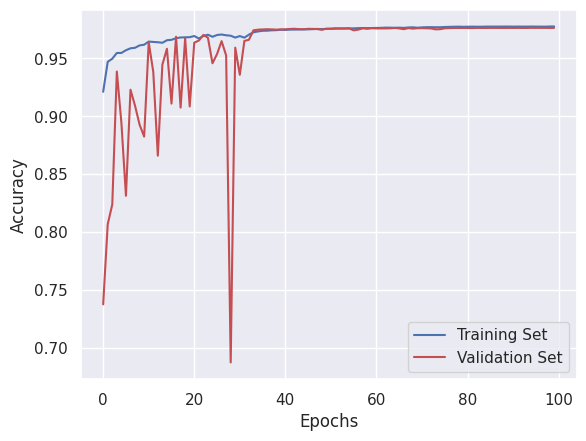

In [47]:
#acc
fig,(ax1) = plt.subplots(1,1)
ax1.plot(epochs, proposed_deeplab['accuracy'], 'b', label='Training Set')
ax1.plot(epochs, proposed_deeplab['val_accuracy'], 'r', label='Validation Set')
ax1.legend(loc='lower right', shadow=True)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

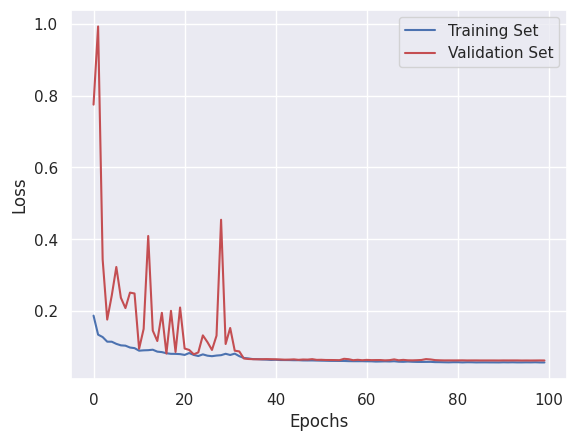

In [48]:
#loss
fig,(ax1) = plt.subplots(1,1)
ax1.plot(epochs, proposed_deeplab['loss'], 'b', label='Training Set')
ax1.plot(epochs, proposed_deeplab['val_loss'], 'r', label='Validation Set')
ax1.legend(loc='lower right', shadow=True)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

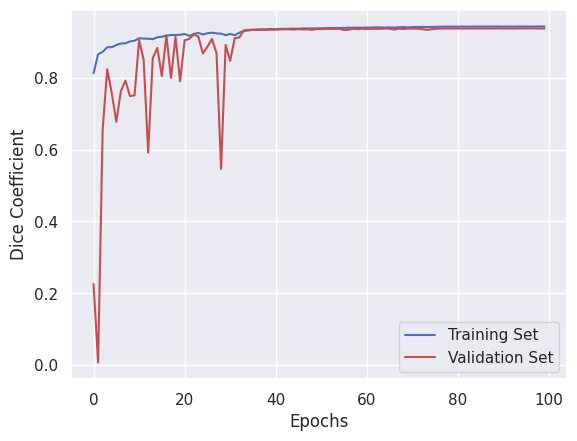

In [49]:
#dice
fig,(ax1) = plt.subplots(1,1)
ax1.plot(epochs, proposed_deeplab['dice_coef'], 'b', label='Training Set')
ax1.plot(epochs, proposed_deeplab['val_dice_coef'], 'r', label='Validation Set')
ax1.legend(loc='lower right', shadow=True)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Dice Coefficient')
ax1.legend()

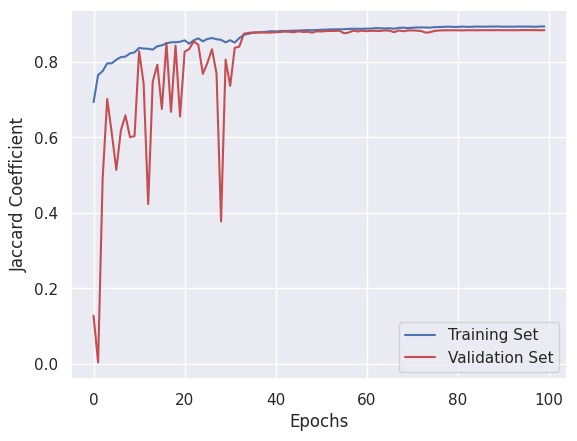

In [50]:
#jaccard
fig,(ax1) = plt.subplots(1,1)
ax1.plot(epochs, proposed_deeplab['jaccard_coef'], 'b', label='Training Set')
ax1.plot(epochs, proposed_deeplab['val_jaccard_coef'], 'r', label='Validation Set')
ax1.legend(loc='lower right', shadow=True)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Jaccard Coefficient')
ax1.legend()

In [51]:
proposed_model = tf.keras.models.load_model('WHU_proposed_model.h5', custom_objects = {'dice_coef': dice_coef,
            'jaccard_coef_loss': jaccard_coef_loss,
            'jaccard_coef':jaccard_coef,
            'dice_coef_loss': dice_coef_loss})

In [52]:
deeplab_val = proposed_model.predict(vl_image)
deeplab_ts = proposed_model.predict(ts_image)

10/10 [==============================] - 1s 116ms/step


In [53]:
deeplab_val_argmax = (deeplab_val > 0.5).astype(np.uint8)
deeplab_ts_argmax = (deeplab_ts > 0.5).astype(np.uint8)

In [54]:
def vis_validation(num):
    fig,(ax1,ax2,ax3) = plt.subplots(1,3)
    fig.set_figheight(7)
    fig.set_figwidth(14)

    ax1.axis('off')
    ax1.imshow(ts_image[num])
    ax1.set_title('Original Image')

    ax2.axis('off')
    ax2.imshow(np.squeeze(ts_mask[num]), cmap='gray') #256x256x1 olan boyutu 256x256 yapmaliyiz onuda np.squeeze ile yapariz.
    ax2.set_title('Original Mask')

    ax3.axis('off')
    ax3.imshow(np.squeeze(deeplab_ts_argmax[num]), cmap='gray') #256x256x1 olan boyutu 256x256 yapmaliyiz onuda np.squeeze ile yapariz.
    ax3.set_title('Proposed Method')

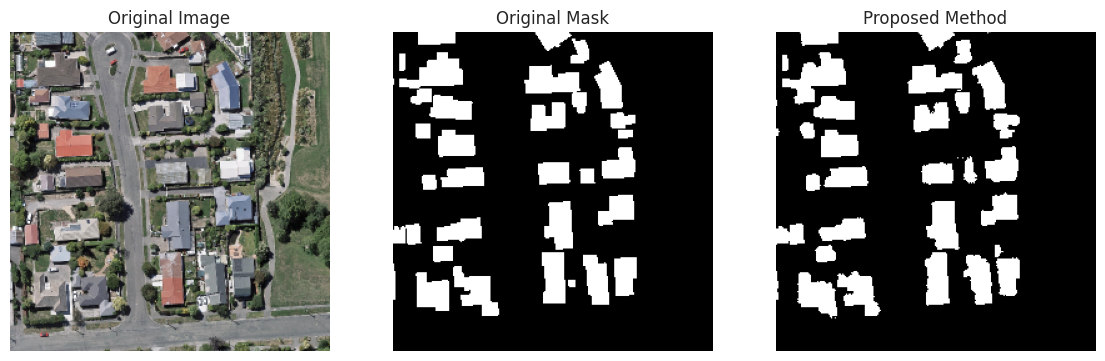

In [55]:
vis_validation(23)